In [ ]:
!pip install accelerate
!pip install datasets
!pip install rich
!pip install transformers>=4.46.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
!pip install trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.3/366.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 20.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!python /content/ppo_tldr.py \
    --dataset_name trl-internal-testing/tldr-preference-sft-trl-style \
    --dataset_test_split validation \
    --learning_rate 3e-6 \
    --output_dir /content/drive/MyDrive/June_11_v_2_ppo_checkpoints/ \
    --per_device_train_batch_size 1 \
    --gradient_accumulation_steps 8 \
    --total_episodes 1000 \
    --model_name_or_path EleutherAI/pythia-1b-deduped \
    --sft_model_path cleanrl/EleutherAI_pythia-1b-deduped__sft__tldr \
    --reward_model_path cleanrl/EleutherAI_pythia-1b-deduped__reward__tldr \
    --missing_eos_penalty 1.0 \
    --stop_token eos \
    --response_length 52 \
    --eval_strategy steps \
    --eval_steps 100 \
    --use_peft True


Streaming output truncated to the last 5000 lines.
│ POST: She was in her       │ Mom: I don't have to give │                     │
│ living room, watching TV.  │ you more respect.         │                     │
│ This was at about 8:30 in  │                           │                     │
│ the morning, and she was   │ TL;DR: Assistant: Mom     │                     │
│ exercising. She turned the │ woke me up with a loud    │                     │
│ TV up extra loud to hear   │ TV.                       │                     │
│ it over her excercycle,    │                           │                     │
│ and woke me up. I went in  │                           │                     │
│ there asking for her to    │                           │                     │
│ turn it down. She said she │                           │                     │
│ didn't have to; I          │                           │                     │
│ explained that I always    │                           │

### policy evaluation

In [6]:
from safetensors.torch import load_file


In [13]:
from transformers import AutoConfig, AutoModel

In [9]:
import torch
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from peft import PeftModel, PeftConfig
from safetensors.torch import load_file
import os

# === Paths ===
base_path = "/content/drive/MyDrive/June_11_v_2_ppo_checkpoints"
value_model_path = os.path.join(base_path, "value_model")
peft_path = base_path

config = AutoConfig.from_pretrained(value_model_path)
value_model = AutoModelForSequenceClassification.from_config(config)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
value_model

GPTNeoXForSequenceClassification(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 2048)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-15): 16 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (query_key_value): Linear(in_features=2048, out_features=6144, bias=True)
          (dense): Linear(in_features=2048, out_features=2048, bias=True)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=2048, out_features=8192, bias=True)
          (dense_4h_to_h): Linear(in_features=8192, out_features=2048, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (final_layer_norm): LayerNorm((2048,

In [16]:
from peft import AutoPeftModel, PeftConfig# Assuming you have the peft library installed

In [19]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel, PeftConfig
import torch

# Your paths
base_model_id = "EleutherAI/pythia-1b-deduped"
adapter_id = base_path  # This should be your fine-tuned adapter path

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model_id)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Method 1: Load using PeftModel (Recommended)
print("Loading base model...")
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    torch_dtype=torch.float16,  # Use float16 for efficiency
    device_map="auto"
)

print("Loading PEFT adapter...")
model = PeftModel.from_pretrained(base_model, adapter_id)

Loading base model...
Loading PEFT adapter...


In [26]:
def generate_text(prompt, max_length=200):
    inputs = tokenizer(prompt, return_tensors="pt")

    # Move inputs to the same device as model
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=max_length,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_text

# Example usage
prompt = '''Moderators aren't employees, they're unpaid and untrained volunteers, so they don't really need to do anything aside from following the moderator code of conduct.

Which is mostly just for setting a consistent experience for a community. Example, this subreddit is for helping new users, so if it were suddenly rebranded to intentionally misleading new users, that could probably be such a violation.

Maybe they did put such a limit somewhere, like in the rules, FAQ, welcome message,'''
result = generate_text(prompt)
print(f"Generated: {result}")


Generated: Moderators aren't employees, they're unpaid and untrained volunteers, so they don't really need to do anything aside from following the moderator code of conduct.

Which is mostly just for setting a consistent experience for a community. Example, this subreddit is for helping new users, so if it were suddenly rebranded to intentionally misleading new users, that could probably be such a violation.

Maybe they did put such a limit somewhere, like in the rules, FAQ, welcome message, or whatever. But the question really is, is a SE-employer allowed to put such a disclaimer on a subreddit? We don't need to see it for ourselves (well, okay, we do need to see whatever they decide to put it on. We don't know anything for sure about it yet.) But they weren't so much the ones who started the whole thing, so they may be a company that can legally enforce it, but I'm not saying that


In [28]:
from datasets import load_dataset

In [29]:
source = "trl-internal-testing/tldr-preference-sft-trl-style"
test_data = load_dataset(source, split="test", download_mode="force_redownload")

train-00000-of-00002.parquet:   0%|          | 0.00/159M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/160M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/17.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/18.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/116722 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6447 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6553 [00:00<?, ? examples/s]

In [31]:
prompt = test_data[0]["prompt"]
inputs = tokenizer(prompt, return_tensors="pt")

# Move inputs to the same device as model (this is the key fix!)
inputs = {k: v.to(model.device) for k, v in inputs.items()}

# Generate with proper parameters
generated_tokens = model.generate(
    **inputs,
    max_length=inputs['input_ids'].shape[1] + 50,  # Generate 50 more tokens
    pad_token_id=tokenizer.eos_token_id,
    do_sample=True,
    temperature=0.7
)

generated_text = tokenizer.decode(generated_tokens[0], skip_special_tokens=True)
print(f"Generated: {generated_text}")

Generated: SUBREDDIT: r/relationships

TITLE: Me [19 F] with my friend [19 M], not sure if I may have messed things up already.

POST: Hello hello everybody. I hope this isn't too trivial of a question to ask on here, but I've been feeling a bit out of my depth when it comes to this situation (I've had only one relationship before, and for many reasons, it was out of the ordinary).

Okay! So, a couple of weeks ago, I started talking to this guy on Facebook, through a student group that we were both part of. I thought he was sort of cute, so I sent him a PM just to talk, etc, etc. We're both transfer students at the same school, so I knew that we could eventually meet in person once we both moved on-campus. So, we did, and we hung out maybe twice, just as friends.

Okay. So, everything is going pretty well. We talk over Facebook and Snapchat, whatever. So, Saturday night, I was just hanging out with people and kind of being bored, when I got a Snapchat from him asking what I was doing. 

In [34]:
def get_reward(prompt, summary):
    # Format input as expected by the reward model (Reddit-style)
    input_text = f"{prompt.strip()}\n\nTL;DR: {summary.strip()}"

    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        # reward = outputs.logits.squeeze().item()  # scalar reward
        reward = outputs.logits[0, -1, :].mean().item()
        value = outputs.logits[0, -1].mean().item()

    return reward, value


In [35]:
get_reward(test_data[0]["prompt"], generated_text)

(0.00969696044921875, 0.00969696044921875)

In [49]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd

def get_intermediate_values(query, response_tokens, model, tokenizer, gamma=0.99):
    """
    Get value estimates for intermediate states: V(<q . a1>), V(<q . a1 . a2>), etc.

    Args:
        query: The input query string
        response_tokens: List of response tokens or full response string
        model: Your PPO-trained model
        tokenizer: Tokenizer
        gamma: Discount factor

    Returns:
        Dictionary with intermediate states and their values
    """
    # Tokenize query
    query_inputs = tokenizer(query, return_tensors="pt", add_special_tokens=False)
    query_ids = query_inputs['input_ids'][0]

    # If response_tokens is a string, tokenize it
    if isinstance(response_tokens, str):
        response_inputs = tokenizer(response_tokens, return_tensors="pt", add_special_tokens=False)
        response_ids = response_inputs['input_ids'][0]
    else:
        # Assume it's already tokenized
        response_ids = torch.tensor(response_tokens)

    results = {
        'states': [],
        'values': [],
        'tokens': [],
        'positions': [],
        'intermediate_texts': []
    }

    # Evaluate V(<q>) - initial query value
    query_text = tokenizer.decode(query_ids, skip_special_tokens=True)
    initial_inputs = tokenizer(query_text, return_tensors="pt")
    initial_inputs = {k: v.to(model.device) for k, v in initial_inputs.items()}

    with torch.no_grad():
        outputs = model(**initial_inputs)
        initial_value = extract_value(outputs)

    results['states'].append('query')
    results['values'].append(initial_value)
    results['tokens'].append('<QUERY>')
    results['positions'].append(0)
    results['intermediate_texts'].append(query_text)

    # Evaluate V(<q . a1>), V(<q . a1 . a2>), etc.
    for i in range(len(response_ids)):
        # Build intermediate sequence: query + response up to position i+1
        intermediate_ids = torch.cat([query_ids, response_ids[:i+1]])
        intermediate_text = tokenizer.decode(intermediate_ids, skip_special_tokens=True)

        # Get value for this intermediate state
        inputs = tokenizer(intermediate_text, return_tensors="pt")
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            value = extract_value(outputs)

        current_token = tokenizer.decode(response_ids[i], skip_special_tokens=True)

        results['states'].append(f'q_a1_to_a{i+1}')
        results['values'].append(value)
        results['tokens'].append(current_token)
        results['positions'].append(i+1)
        results['intermediate_texts'].append(intermediate_text)

    return results

def extract_value(outputs):
    """Extract value from model outputs - adjust based on your model architecture"""
    # First, let's check what attributes the outputs actually have
    # print("Available attributes:", [attr for attr in dir(outputs) if not attr.startswith('_')])

    # Try different common value extraction methods
    if hasattr(outputs, 'value') and torch.is_tensor(outputs.value):
        return outputs.value[0, -1].item()
    elif hasattr(outputs, 'values') and torch.is_tensor(outputs.values):
        return outputs.values[0, -1].item()
    elif hasattr(outputs, 'logits'):
        # For many PPO implementations, value might be extracted from logits
        # This is a common fallback - you might need to adjust based on your specific model
        if outputs.logits.dim() == 3:  # [batch, seq_len, vocab_size]
            # Method 1: Take mean of last token's logits
            return outputs.logits[0, -1].mean().item()
        elif outputs.logits.dim() == 2:  # [batch, vocab_size]
            return outputs.logits[0].mean().item()
        else:
            return outputs.logits.mean().item()
    else:
        # Last resort - check if there's a hidden state we can use
        if hasattr(outputs, 'last_hidden_state'):
            return outputs.last_hidden_state[0, -1].mean().item()
        else:
            raise ValueError("Cannot extract value from model outputs. Please check your model architecture.")

def debug_model_outputs(model, tokenizer, text="Hello world"):
    """Helper function to debug what your model actually outputs"""
    inputs = tokenizer(text, return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    print("Model output type:", type(outputs))
    print("Available attributes:", [attr for attr in dir(outputs) if not attr.startswith('_')])

    for attr in ['logits', 'value', 'values', 'last_hidden_state']:
        if hasattr(outputs, attr):
            attr_value = getattr(outputs, attr)
            if torch.is_tensor(attr_value):
                print(f"{attr} shape: {attr_value.shape}")
            elif callable(attr_value):
                print(f"{attr} is a method/function")
            else:
                print(f"{attr} type: {type(attr_value)}")

    return outputs

def analyze_td_properties(values, gamma=0.99, final_reward=None):
    """
    Analyze Temporal Difference properties of the value function

    Args:
        values: List of value estimates for each state
        gamma: Discount factor
        final_reward: Final reward r(<q . a>) if available

    Returns:
        Dictionary with TD analysis results
    """
    values = np.array(values)
    n = len(values)

    # Calculate TD errors: δ_t = r_t + γ V(s_{t+1}) - V(s_t)
    # In sparse reward setting, r_t = 0 for all intermediate steps, r_final = final_reward
    td_errors = []

    for i in range(n - 1):
        # TD error: δ_t = 0 + γ V(s_{t+1}) - V(s_t)
        td_error = gamma * values[i + 1] - values[i]
        td_errors.append(td_error)

    # For final state, if we have the final reward
    if final_reward is not None:
        # δ_final = r_final + γ * 0 - V(s_final) = r_final - V(s_final)
        final_td_error = final_reward - values[-1]
        td_errors.append(final_td_error)

    # Calculate expected discounted return from each position
    if final_reward is not None:
        expected_returns = []
        for i in range(n):
            # In sparse reward: G_t = γ^{T-t} * r_final
            steps_to_end = (n - 1) - i
            expected_return = (gamma ** steps_to_end) * final_reward
            expected_returns.append(expected_return)
    else:
        expected_returns = None

    return {
        'td_errors': td_errors,
        'td_error_mean': np.mean(td_errors),
        'td_error_std': np.std(td_errors),
        'td_error_variance': np.var(td_errors),
        'value_variance': np.var(values),
        'value_progression': values,
        'expected_returns': expected_returns,
        'value_vs_expected_error': np.mean((values - expected_returns)**2) if expected_returns else None
    }

def evaluate_multiple_responses(query, responses, model, tokenizer, gamma=0.99, rewards=None):
    """
    Evaluate value function for multiple responses to the same query

    Args:
        query: The input query
        responses: List of response strings
        model: PPO model
        tokenizer: Tokenizer
        gamma: Discount factor
        rewards: List of final rewards for each response (optional)
    """
    all_results = []

    for i, response in enumerate(responses):
        print(f"\nAnalyzing response {i+1}: {response[:50]}...")

        # Get intermediate values
        result = get_intermediate_values(query, response, model, tokenizer, gamma)

        # Get final reward if provided
        final_reward = rewards[i] if rewards else None

        # Analyze TD properties
        td_analysis = analyze_td_properties(result['values'], gamma, final_reward)

        # Combine results
        combined_result = {
            'response_id': i,
            'response_text': response,
            'intermediate_analysis': result,
            'td_analysis': td_analysis,
            'final_reward': final_reward
        }

        all_results.append(combined_result)

    return all_results

def plot_value_analysis(results, title="Value Function Analysis"):
    """Plot value progression and TD analysis"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(title)

    # Plot 1: Value progression for each response
    ax1 = axes[0, 0]
    for i, result in enumerate(results):
        values = result['td_analysis']['value_progression']
        positions = result['intermediate_analysis']['positions']
        ax1.plot(positions, values, marker='o', label=f'Response {i+1}')

        # Plot expected returns if available
        if result['td_analysis']['expected_returns']:
            expected = result['td_analysis']['expected_returns']
            ax1.plot(positions, expected, '--', alpha=0.7, label=f'Expected {i+1}')

    ax1.set_xlabel('Token Position')
    ax1.set_ylabel('Value Estimate')
    ax1.set_title('Value Progression During Generation')
    ax1.legend()
    ax1.grid(True)

    # Plot 2: TD errors
    ax2 = axes[0, 1]
    for i, result in enumerate(results):
        td_errors = result['td_analysis']['td_errors']
        ax2.plot(td_errors, marker='s', label=f'Response {i+1}')

    ax2.set_xlabel('Step')
    ax2.set_ylabel('TD Error')
    ax2.set_title('Temporal Difference Errors')
    ax2.legend()
    ax2.grid(True)

    # Plot 3: Value variance comparison
    ax3 = axes[1, 0]
    response_ids = [r['response_id'] for r in results]
    value_vars = [r['td_analysis']['value_variance'] for r in results]
    td_vars = [r['td_analysis']['td_error_variance'] for r in results]

    x = np.arange(len(response_ids))
    width = 0.35
    ax3.bar(x - width/2, value_vars, width, label='Value Variance')
    ax3.bar(x + width/2, td_vars, width, label='TD Error Variance')
    ax3.set_xlabel('Response ID')
    ax3.set_ylabel('Variance')
    ax3.set_title('Variance Comparison')
    ax3.set_xticks(x)
    ax3.set_xticklabels([f'Resp {i+1}' for i in response_ids])
    ax3.legend()

    # Plot 4: Summary statistics
    ax4 = axes[1, 1]
    td_means = [r['td_analysis']['td_error_mean'] for r in results]
    td_stds = [r['td_analysis']['td_error_std'] for r in results]

    ax4.scatter(td_means, td_stds, s=100, alpha=0.7)
    for i, (mean, std) in enumerate(zip(td_means, td_stds)):
        ax4.annotate(f'Resp {i+1}', (mean, std), xytext=(5, 5),
                    textcoords='offset points')

    ax4.set_xlabel('TD Error Mean')
    ax4.set_ylabel('TD Error Std')
    ax4.set_title('TD Error Statistics')
    ax4.grid(True)

    plt.tight_layout()
    return fig

# Example usage - First debug your model to understand its outputs
def run_comprehensive_analysis():
    """Run comprehensive value function analysis"""

    # First, let's debug what your model actually outputs
    print("Debugging model outputs...")
    debug_outputs = debug_model_outputs(model, tokenizer)
    print("\n" + "="*50)

    # Example: Analyze multiple responses to the same query
    query = test_data[0]["prompt"]

    # Generate multiple responses (you can replace this with your actual responses)
    responses = []
    rewards = []

    try:
        for i in range(3):  # Generate 3 different responses
            # Generate response
            inputs = tokenizer(query, return_tensors="pt")
            inputs = {k: v.to(model.device) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_length=inputs['input_ids'].shape[1] + 50,
                    do_sample=True,
                    temperature=0.7 + i * 0.3,  # Different temperatures for variety
                    pad_token_id=tokenizer.eos_token_id
                )

            response = tokenizer.decode(outputs[0], skip_special_tokens=True)
            response = response[len(query):].strip()  # Remove query part
            responses.append(response)

            # Get reward (using your existing get_reward function)
            reward, _ = get_reward(query, response)
            rewards.append(reward)

        # Add a negative response example
        negative_response = "This is a bad response that doesn't answer the question properly."
        responses.append(negative_response)
        negative_reward, _ = get_reward(query, negative_response)
        rewards.append(negative_reward)

        print(f"Query: {query}")
        print(f"Generated {len(responses)} responses with rewards: {rewards}")

        # Analyze all responses
        results = evaluate_multiple_responses(query, responses, model, tokenizer,
                                            gamma=0.99, rewards=rewards)

        # Print summary
        print("\n" + "="*80)
        print("SUMMARY ANALYSIS")
        print("="*80)

        for i, result in enumerate(results):
            td_analysis = result['td_analysis']
            print(f"\nResponse {i+1}:")
            print(f"  Final Reward: {result['final_reward']:.4f}")
            print(f"  Initial Value: {td_analysis['value_progression'][0]:.4f}")
            print(f"  Final Value: {td_analysis['value_progression'][-1]:.4f}")
            print(f"  TD Error Mean: {td_analysis['td_error_mean']:.4f}")
            print(f"  TD Error Std: {td_analysis['td_error_std']:.4f}")
            print(f"  Value Variance: {td_analysis['value_variance']:.4f}")
            if td_analysis['value_vs_expected_error']:
                print(f"  Value vs Expected MSE: {td_analysis['value_vs_expected_error']:.4f}")

        # Create visualization
        fig = plot_value_analysis(results, f"Value Analysis for Query: {query[:30]}...")
        plt.show()

        return results

    except Exception as e:
        print(f"Error during analysis: {e}")
        print("Please check the debug output above to understand your model's structure")
        return None

Debugging model outputs...
Model output type: <class 'transformers.modeling_outputs.CausalLMOutputWithPast'>
Available attributes: ['attentions', 'clear', 'copy', 'fromkeys', 'get', 'hidden_states', 'items', 'keys', 'logits', 'loss', 'move_to_end', 'past_key_values', 'pop', 'popitem', 'setdefault', 'to_tuple', 'update', 'values']
logits shape: torch.Size([1, 2, 50304])
values is a method/function

Query: SUBREDDIT: r/relationships

TITLE: Me [19 F] with my friend [19 M], not sure if I may have messed things up already.

POST: Hello hello everybody. I hope this isn't too trivial of a question to ask on here, but I've been feeling a bit out of my depth when it comes to this situation (I've had only one relationship before, and for many reasons, it was out of the ordinary).

Okay! So, a couple of weeks ago, I started talking to this guy on Facebook, through a student group that we were both part of. I thought he was sort of cute, so I sent him a PM just to talk, etc, etc. We're both trans

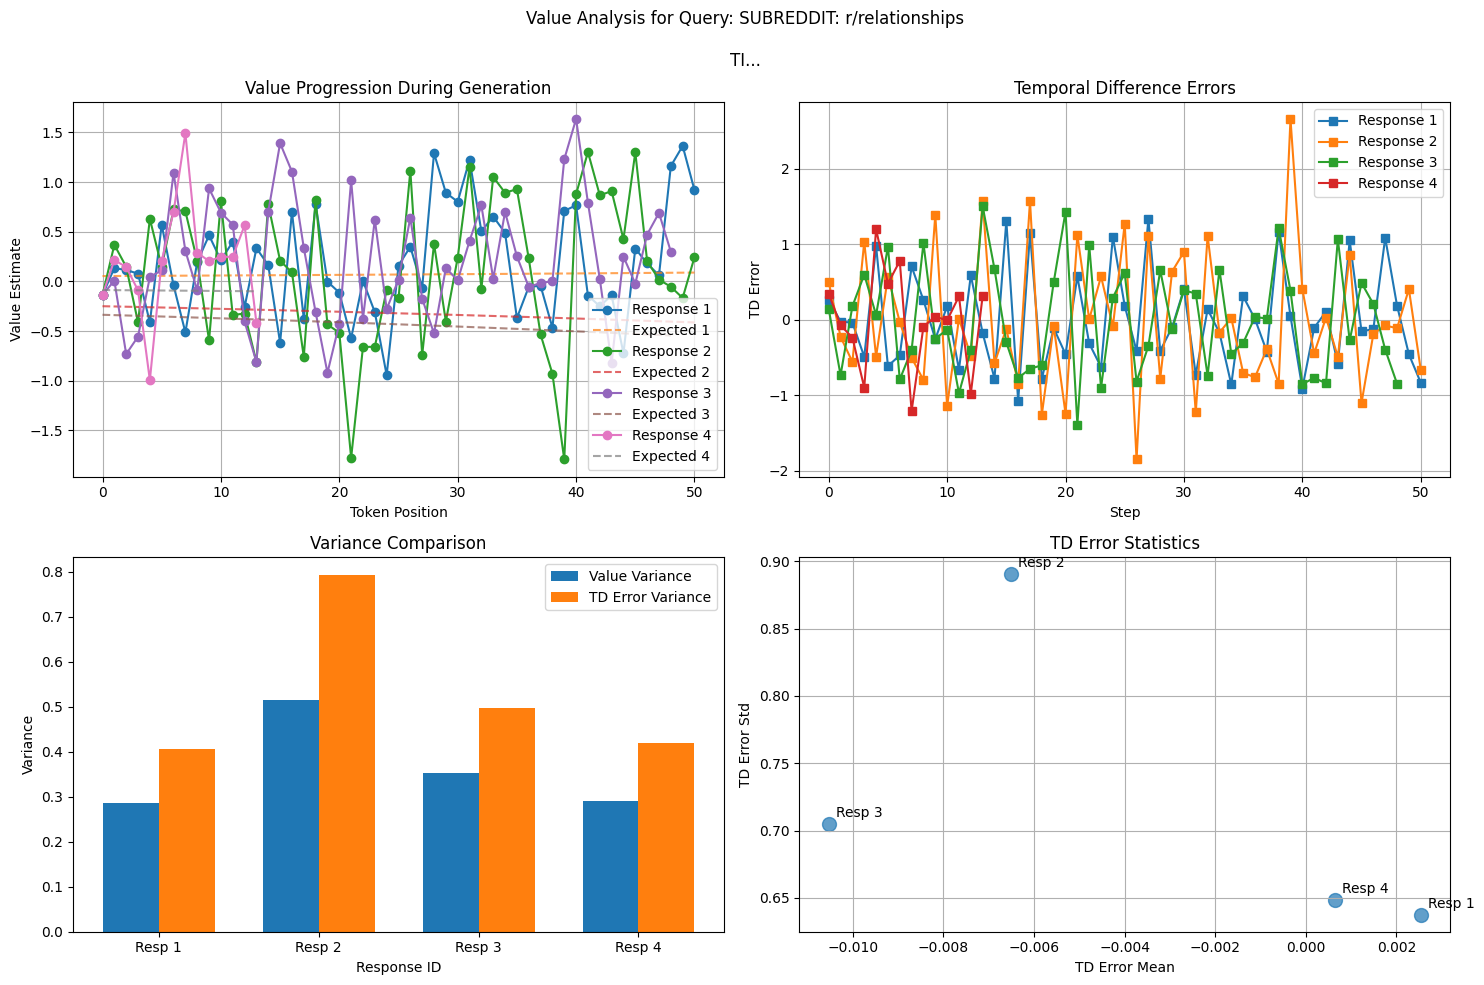

[{'response_id': 0,
  'response_text': "Has anyone had similar experiences with a guy and not wanting to commit to a relationship? I'm probably going to be really torn on this, and I don't know how to ask this. I've been feeling a bit out of my depth, and",
  'intermediate_analysis': {'states': ['query',
    'q_a1_to_a1',
    'q_a1_to_a2',
    'q_a1_to_a3',
    'q_a1_to_a4',
    'q_a1_to_a5',
    'q_a1_to_a6',
    'q_a1_to_a7',
    'q_a1_to_a8',
    'q_a1_to_a9',
    'q_a1_to_a10',
    'q_a1_to_a11',
    'q_a1_to_a12',
    'q_a1_to_a13',
    'q_a1_to_a14',
    'q_a1_to_a15',
    'q_a1_to_a16',
    'q_a1_to_a17',
    'q_a1_to_a18',
    'q_a1_to_a19',
    'q_a1_to_a20',
    'q_a1_to_a21',
    'q_a1_to_a22',
    'q_a1_to_a23',
    'q_a1_to_a24',
    'q_a1_to_a25',
    'q_a1_to_a26',
    'q_a1_to_a27',
    'q_a1_to_a28',
    'q_a1_to_a29',
    'q_a1_to_a30',
    'q_a1_to_a31',
    'q_a1_to_a32',
    'q_a1_to_a33',
    'q_a1_to_a34',
    'q_a1_to_a35',
    'q_a1_to_a36',
    'q_a1_to_a37',


In [50]:
run_comprehensive_analysis()